In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [19]:
#loading data frame, assigning column names, changing angina column to factor type, & selecting the columns we need
heart_data <- read_csv(url("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"), col_names = FALSE) |>
    rename(age=X1, sex=X2,chest_pain_type=X3, resting_blood_pressure=X4, serum_cholestoral=X5, fasting_blood_sugar=X6,
           resting_electrocardiographic_results=X7, max_heart_rate=X8, exercise_induced_angina=X9, ST_depression=X10,
           slope=X11, number_vessels=X12, thal=X13, angiographic_status=X14) |>
    mutate(exercise_induced_angina=as.factor(exercise_induced_angina)) |> 
    mutate(sex=as.factor(sex)) |>
    mutate(resting_electrocardiographic_results=as.factor(resting_electrocardiographic_results)) |>
    mutate(angiographic_status=as.factor(angiographic_status)) |>
    select(age, sex, resting_blood_pressure, serum_cholestoral, resting_electrocardiographic_results, exercise_induced_angina, angiographic_status)
heart_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,resting_blood_pressure,serum_cholestoral,resting_electrocardiographic_results,exercise_induced_angina,angiographic_status
<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>
63,1,145,233,2,0,0
67,1,160,286,2,1,2
67,1,120,229,2,1,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,130,131,0,1,3
57,0,130,236,2,0,1
38,1,138,175,0,0,0


In [40]:
#we should make sure 0.75 is an appropriate proportion to use 
heart_split <- initial_split(heart_data, prop = 0.75, strata = sex)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

In [42]:
#i opted not to add sex becuase i thought the chart might be a little too big but feel free to add it to see what it looks like
#added rounding because it's harder to read with 6 decimals following each number
#not sure if i like having the n=n() - they did suggest it in the assignment but i feel like it doesn't add much value here
mean_age_angiographic <- heart_train |>
    group_by(angiographic_status) |>
    summarize(mean_age=round(mean(age),1), mean_cholesteral = round(mean(serum_cholestoral)), n=n())
mean_age_angiographic

#i liked this graph but maybe a little less relevant now
# training_summarized <- heart_train |> 
#     group_by(exercise_induced_angina, sex) |> 
#     summarize(n=n())
# training_summarized

# chart is a little big for a summary
# training_summarized_2 <- heart_train |> 
#    group_by(exercise_induced_angina, age) |> 
#    summarize(n=n())
# training_summarized_2


angiographic_status,mean_age,mean_cholesteral,n
<fct>,<dbl>,<dbl>,<int>
0,53.2,241,117
1,55.9,250,43
2,57.0,261,26
3,55.9,246,28
4,59.4,241,12


In [32]:
#colors yayy
library(RColorBrewer)
#display.brewer.all()


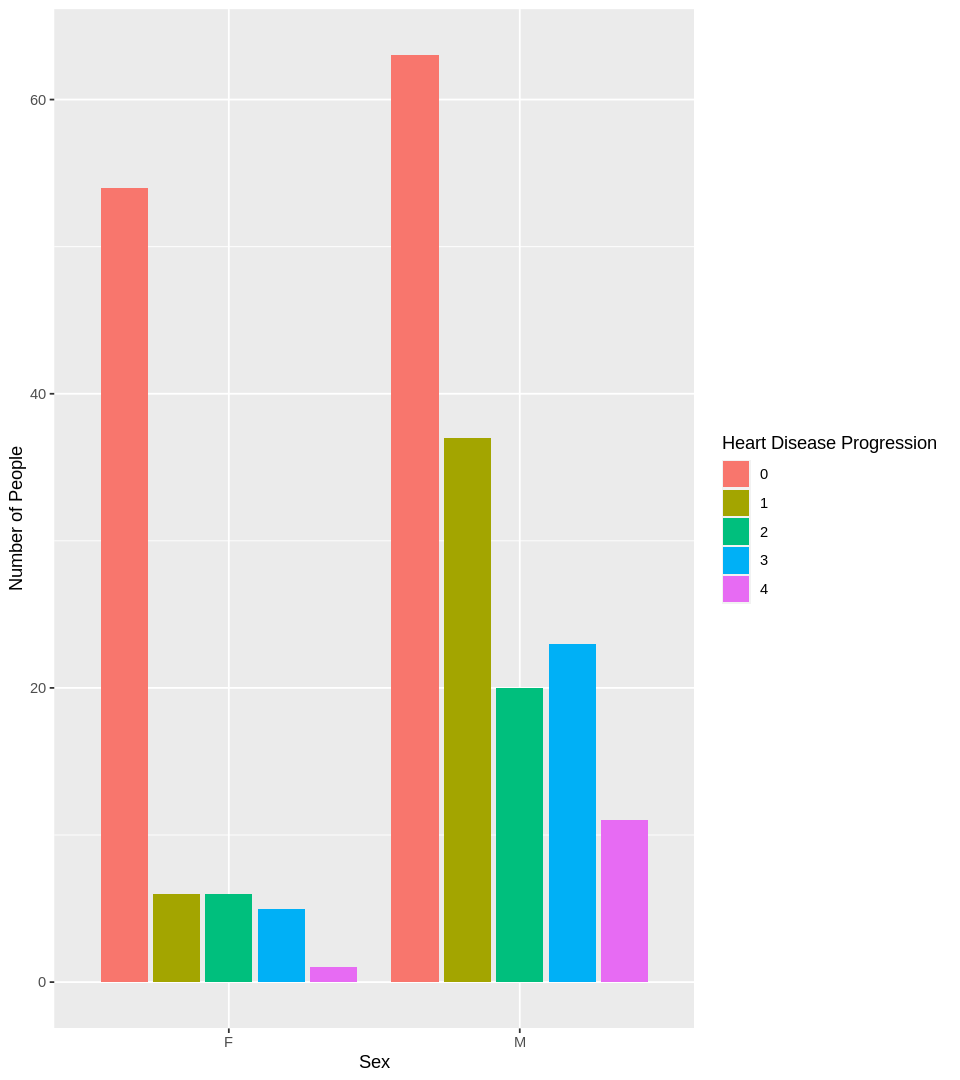

In [67]:
#tried to color by age like I did for sex in the next plot but it didn't work for some reason
# age_dist <- training_summarized_2 |> 
#     ggplot(aes(x=age, y=n)) +
#     geom_bar(stat="identity") + 
#     labs(x="Age", y="Number with exercise-induced angina") +
#     theme(text=element_text(size=20)) + 
#     scale_fill_brewer(palette="PuRd")
# age_dist

#converts numerical sex value into a letter eg 0 -> F. Creates a new column for it
temp_heart_train <- heart_train
temp_heart_train["sex_letter"] <- NA
for(i in 1:nrow(temp_heart_train)) {
    if(temp_heart_train[i, 2] == 0) {
        temp_heart_train[i, ncol(temp_heart_train)] <- "F"
    } else {
        temp_heart_train[i, ncol(temp_heart_train)] <- "M"
    }    
}
#temp_heart_train
options(repr.plot.width = 8, repr.plot.height = 9)
heart_plot <- temp_heart_train |> 
    ggplot(aes(x = sex_letter, fill = angiographic_status)) +
    geom_bar(position = "dodge2") +
    xlab("Sex") +
    ylab("Number of People") +
    labs(fill = "Heart Disease Progression") #not sure if this is the right thing to call it
heart_plot

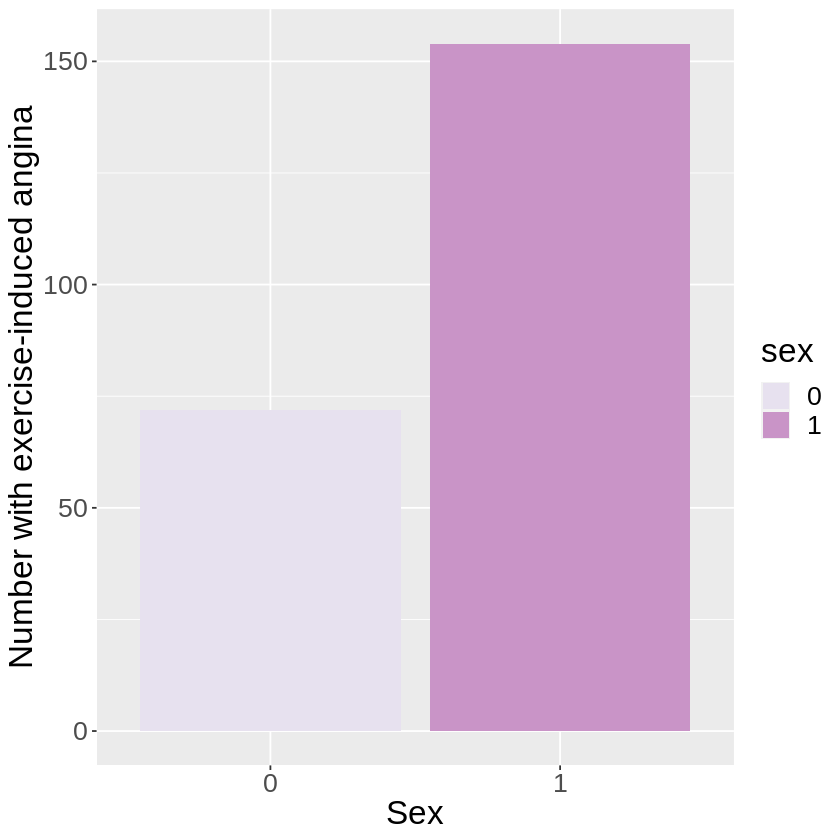

In [68]:
angina_by_sex <- training_summarized |>
    ggplot(aes(x=sex, y=n, fill=sex)) +
    geom_bar(stat="identity") + 
    labs(x="Sex", y="Number with exercise-induced angina", fill="Sex") +
    theme(text=element_text(size=20)) +
    scale_fill_brewer(palette="PuRd")
angina_by_sex